In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
import nilmtk.utils

%matplotlib inline
rcParams['figure.figsize'] = (13, 6)

In [2]:
train = DataSet(r'.\data\redd.h5')
test = DataSet(r'.\data\redd.h5')

building = 1

train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

In [154]:
import numpy as np

def load_train(appliance):
    d = {range(6, 12): 'morning', range(12, 18): 'afternoon', range(18, 24): 'night', range(0, 6): 'night'}

    df = next(train_elec[appliance].load())
    df.columns = df.columns.droplevel()
    df = df.rename(columns={'active': 'power'})

    df['time'] = df.index
    df['hour'] = df['time'].dt.hour
    df['turn'] = df['hour'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    df['state'] = df['power'].apply(lambda x: 1 if x > 50 else 0)
    df['total_cons'] = next(train_elec.mains().load())['power']['apparent']
    df['power_simple'] = df['total_cons'] - df['total_cons'] % 100
    df.loc[df['power_simple'] >= 500, 'power_simple'] = df['total_cons'] - df['total_cons'] % 200
    df.loc[df['power_simple'] >= 1000, 'power_simple'] = df['total_cons'] - df['total_cons'] % 1000
    df.loc[df['power_simple'] >= 3000, 'power_simple'] = df['total_cons'] - df['total_cons'] % 2000
    df['state'] = df['state'].astype('category')
    
    df['id'] = 0
    df['use_time'] = df.power_simple.groupby([df.id, df.power_simple.diff().ne(0).cumsum()]).transform('size')
    df['use_time'] = df['use_time'] - df['use_time'] % 10
    df.loc[df['use_time'] >= 30, 'use_time'] = df['use_time'] - df['use_time'] % 30
    df.loc[df['use_time'] >= 60, 'use_time'] = df['use_time'] - df['use_time'] % 60
    df.loc[df['use_time'] >= 120, 'use_time'] = df['use_time'] - df['use_time'] % 120
    df.loc[df['use_time'] >= 240, 'use_time'] = 240
    df['use_time'] = df['use_time'].astype(int).astype(str)
    df = df.drop(columns=['id'])
    
    return df

In [195]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

def calc_conditional(df):
#     cond = df.groupby(['turn', 'power_simple', 'state']).count().fillna(0)['power']
    cond = df.groupby(['turn', 'power_simple', 'use_time',  'state']).count().fillna(0)['power']
    for i in range(int(cond.size / 2)):
        sum_cond = cond.iloc[2 * i] + cond.iloc[2 * i + 1]
        cond.iloc[2 * i] /= sum_cond
        cond.iloc[2 * i + 1] /= sum_cond
    return cond.fillna(0)

def create_bbn(df):
    cons_df = df.groupby('power_simple').size()
    cons_df = cons_df.div(cons_df.sum())
    cons_probs = cons_df.to_numpy()
    cons_names = cons_df.index.astype(int).astype(str).values
    time_probs = df.groupby('use_time').size().div(cons_df.sum()).to_numpy()
    cond = calc_conditional(df)
    cond_probs = cond.to_numpy().flatten()

    turn = BbnNode(Variable(0, 'turn', ['afternoon', 'morning', 'night', 'late_night']), [0.25, 0.25, 0.25, 0.25])
    consumption = BbnNode(Variable(1, 'consumption', cons_names), cons_probs)
    use_time = BbnNode(Variable(2, 'use time', ['0', '10', '20', '30', '60', '120', '240']), time_probs)
    state = BbnNode(Variable(3, 'state', ['off', 'on']), cond_probs)

    bbn = Bbn() \
        .add_node(consumption) \
        .add_node(turn) \
        .add_node(use_time) \
        .add_node(state) \
        .add_edge(Edge(consumption, state, EdgeType.DIRECTED)) \
        .add_edge(Edge(turn, state, EdgeType.DIRECTED)) \
        .add_edge(Edge(use_time, state, EdgeType.DIRECTED))
    return bbn

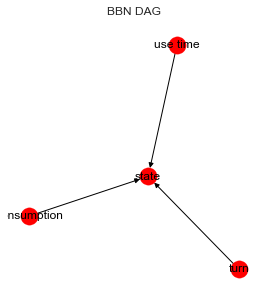

In [278]:
from pybbn.generator.bbngenerator import convert_for_drawing
import matplotlib.pyplot as plt
import networkx as nx
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(10, 5))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')

In [196]:
def load_test():
    d = {range(6, 12): 'morning', range(12, 18): 'afternoon', range(18, 24): 'night', range(0, 6): 'night'}
    
    test_df = next(test_elec.mains().load())
    test_df.columns = test_df.columns.droplevel()
    test_df = test_df.rename(columns={'apparent': 'cons'})
    test_df = test_df.resample('T').mean()
    test_df = test_df.dropna()
    
    test_df['time'] = test_df.index
    test_df['hour'] = test_df['time'].dt.hour
    test_df['turn'] = test_df['hour'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    test_df['cons'] = test_df['cons'] - test_df['cons'] % 100
    test_df.loc[test_df['cons'] >= 500, 'cons'] = test_df['cons'] - test_df['cons'] % 200
    test_df.loc[test_df['cons'] >= 1000, 'cons'] = test_df['cons'] - test_df['cons'] % 1000
    test_df.loc[test_df['cons'] >= 3000, 'cons'] = test_df['cons'] - test_df['cons'] % 2000
    test_df.loc[test_df['cons'] >= 7000, 'cons'] = 6000
#     test_df['cons'] = test_df['cons'].astype(int).astype(str)
    test_df = test_df.drop(columns=['time', 'hour'])
    
    test_df['id'] = 0
    test_df['use_time'] = test_df.cons.groupby([test_df.id, test_df.cons.diff().ne(0).cumsum()]).transform('size')
    test_df['use_time'] = test_df['use_time'] - test_df['use_time'] % 10
    test_df.loc[test_df['use_time'] >= 30, 'use_time'] = test_df['use_time'] - test_df['use_time'] % 30
    test_df.loc[test_df['use_time'] >= 60, 'use_time'] = test_df['use_time'] - test_df['use_time'] % 60
    test_df.loc[test_df['use_time'] >= 120, 'use_time'] = test_df['use_time'] - test_df['use_time'] % 120
    test_df.loc[test_df['use_time'] >= 240, 'use_time'] = 240
    test_df['use_time'] = test_df['use_time'].astype(int).astype(str)
    test_df = test_df.drop(columns=['id'])
    
    test_df['cons'] = test_df['cons'].astype(int).astype(str)
    
    true_y = next(test_elec[appliance].load())
    true_y = true_y.resample('T').mean()
    true_y = true_y.dropna()
    true_y = true_y['power']['active'].apply(lambda x: 1 if x > 50 else 0)
    true_y.name = 'y'
    test_df = pd.concat([test_df, true_y], axis=1, join='inner')

    return test_df

In [221]:
import copy
from pybbn.graph.potential import Potential

def single_predict(cons, turn, time):
     # convert the BBN to a join tree
    join_tree = InferenceController.apply(bbn)

    # insert an observation evidence
    ev = EvidenceBuilder() \
        .with_node(join_tree.get_bbn_node_by_name('consumption')) \
        .with_evidence(str(cons), 1.0) \
        .build()

    join_tree.set_observation(ev)

    # insert an observation evidence
    ev = EvidenceBuilder() \
        .with_node(join_tree.get_bbn_node_by_name('turn')) \
        .with_evidence(turn, 1.0) \
        .build()
    
    join_tree.set_observation(ev)

    # insert an observation evidence
    ev = EvidenceBuilder() \
        .with_node(join_tree.get_bbn_node_by_name('use time')) \
        .with_evidence(time, 1.0) \
        .build()
    
    join_tree.set_observation(ev)

    node = join_tree.get_bbn_node(3)
    return Potential.to_dict([join_tree.get_bbn_potential(node)])['3=on']

def map_preds(bbn, df):
    cons_list = df['cons'].unique()
    turn_list = df['turn'].unique()
    time_list = df['use_time'].unique()
    time_dict = dict((time, 0) for time in time_list)
    pred_map = dict((cons,dict((turn, copy.deepcopy(time_dict)) for turn in turn_list)) for cons in cons_list)
    for cons in cons_list:
        for turn in turn_list:
            for time in time_list:
                pred_map[cons][turn][time] = single_predict(cons, turn, time)
    return pred_map
            
    
def predict(bbn, df):
    pred_map = map_preds(bbn, df)
#     y_pred = df[['cons', 'turn']].apply(lambda x: single_predict(x.cons, x.turn), axis=1)
    y_pred = df[['cons', 'turn', 'use_time']].apply(lambda x: pred_map[x.cons][x.turn][x.use_time], axis=1)
    return y_pred.apply(lambda x: 0 if x < 0.5 else 1)

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


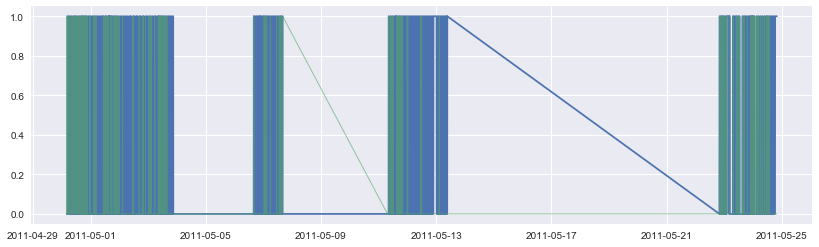

Accuracy:  0.7810617621074613
F1 Score:  0.4747591522157996
ROC AUC:  0.6511656696398133
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


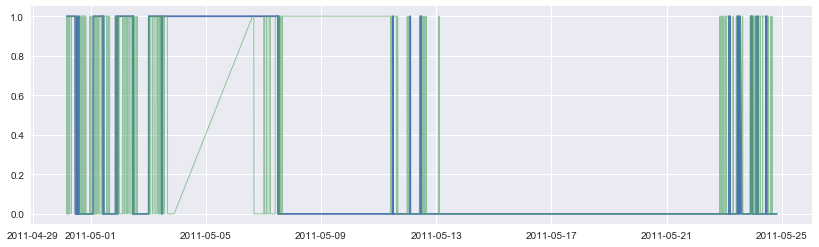

Accuracy:  0.6203517789735764
F1 Score:  0.49514044643810745
ROC AUC:  0.5956423979714226
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


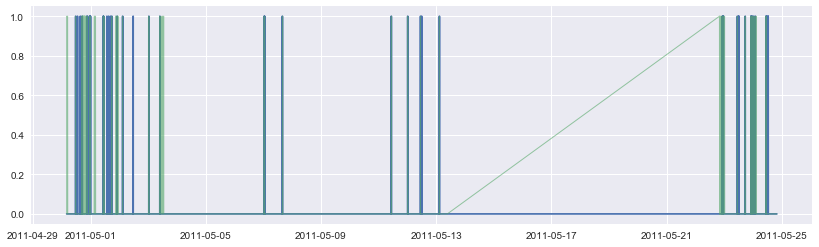

Accuracy:  0.9627339169544615
F1 Score:  0.24675324675324678
ROC AUC:  0.696442379956356
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\TiagoFujii\anaconda3\envs\nilm\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


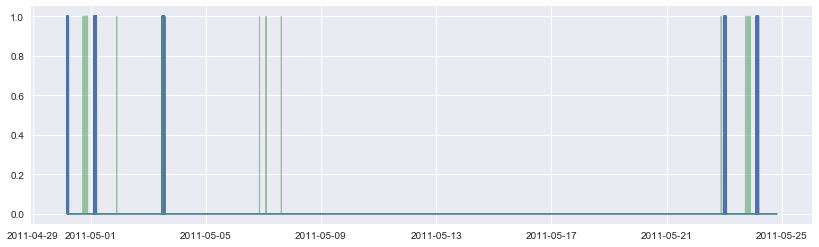

Accuracy:  0.9465103204561882
F1 Score:  0.02915451895043732
ROC AUC:  0.5028751880734396


In [223]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from matplotlib import pyplot as plt

plt.style.use('seaborn')

appliances = ['fridge', 'light', 'microwave', 'dish washer']
# appliances = ['fridge']

for appliance in appliances:
    train_df = load_train(appliance)
    bbn = create_bbn(train_df)
#     Bbn.to_csv(bbn, 'bbn_nilm.csv')
    test_df = load_test()
    y_pred = predict(bbn, test_df)
    
    plt.figure(figsize=(14, 4))
    plt.plot(test_df['y'])
    plt.plot(y_pred, alpha=0.6, linewidth=1)
    plt.show()
    print('Accuracy: ', accuracy_score(test_df['y'], y_pred))
    print('F1 Score: ', f1_score(test_df['y'], y_pred))
    print('ROC AUC: ', roc_auc_score(test_df['y'], y_pred))

In [119]:
train_df['use_time'] = train_df.power_simple.groupby([train_df.id, train_df.power_simple.diff().ne(0).cumsum()]).transform('size')
train_df['use_time'] = train_df['use_time'] - train_df['use_time'] % 10
train_df.loc[train_df['use_time'] >= 30, 'use_time'] = train_df['use_time'] - train_df['use_time'] % 30
train_df.loc[train_df['use_time'] >= 60, 'use_time'] = train_df['use_time'] - train_df['use_time'] % 60
train_df.loc[train_df['use_time'] >= 120, 'use_time'] = train_df['use_time'] - train_df['use_time'] % 120
train_df.loc[train_df['use_time'] >= 240, 'use_time'] = 240
train_df['use_time'] = train_df['use_time'].astype(int).astype(str)
# train_df['use_time'].head(1000).plot()

In [275]:
# appliances = ['fridge', 'light', 'microwave', 'dish washer']
train_df = load_train('dish washer')
# bbn = create_bbn(train_df)

def calc_cond2(df):
    #     cond = df.groupby(['turn', 'power_simple', 'state']).count().fillna(0)['power']
    cond = df.groupby(['use_time',  'state']).count().fillna(0)['power']
    for i in range(int(cond.size / 2)):
        sum_cond = cond.iloc[2 * i] + cond.iloc[2 * i + 1]
        cond.iloc[2 * i] /= sum_cond
        cond.iloc[2 * i + 1] /= sum_cond
    return cond.fillna(0)
cond = calc_cond2(train_df)
cond = cond.to_frame()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [276]:
cond = cond.unstack()['power', 1]
cond.index = pd.to_numeric(cond.index)
cond = cond.sort_index()

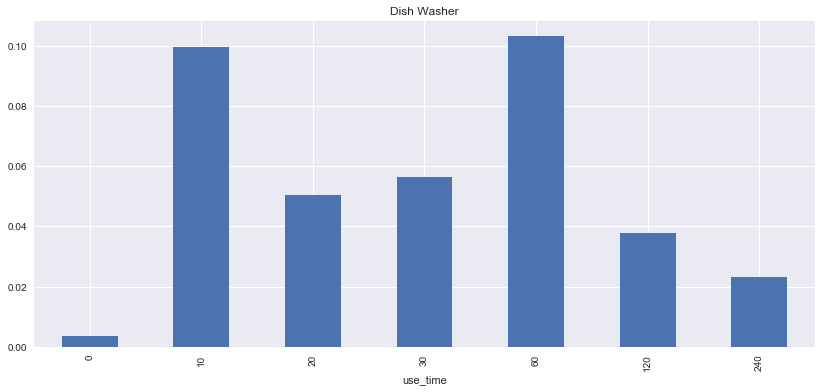

In [277]:
plt.figure(figsize=(14, 6))
plt.title('Dish Washer')
cond.plot.bar()

In [234]:
import seaborn as sns

plt.figure(figsize=(10, 4), dpi=300)
sns.heatmap(cond.unstack().unstack()['power', 1].transpose(), annot=True)
plt.title('Conditional Probability of Appliance being On')
plt.xlabel('Power Consumption (W)')
plt.ylabel('Period of Day')
ax = plt.gca()
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (7, 1) and (7,))

<Figure size 3000x1200 with 0 Axes>

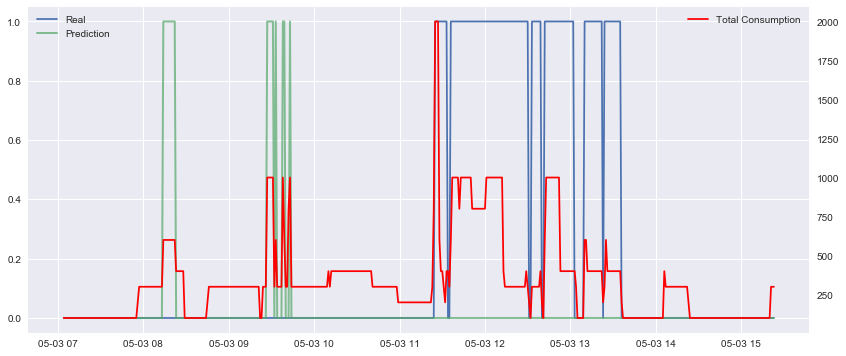

In [70]:
start = 4500
end = start + 500

plt.figure(figsize=(14, 6))
ax1 = plt.gca()
plt.plot(test_df['y'].iloc[start:end])
plt.plot(y_pred.iloc[start:end], alpha=0.7, linewidth=2)
plt.legend(['Real', 'Prediction'], loc='upper left')
ax2 = ax2 = ax1.twinx()
ax2.plot(test_df['cons'].iloc[start:end].astype('int'), 'red')
plt.legend(['Total Consumption'], loc='upper right')
plt.grid(False)
plt.show()